## loading

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import (
    adjusted_rand_score, 
    normalized_mutual_info_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, TruncatedSVD, NMF
import umap
import hdbscan
from scipy.optimize import linear_sum_assignment


## QUESTION 1: Report the dimensions of the TF-IDF matrix you obtain.

In [2]:
# Define two categories
categories = [
    'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
    'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey'
]

# Load the dataset
print("Loading the dataset...")
newsgroups = fetch_20newsgroups(subset='all', categories=categories, remove=('headers', 'footers', 'quotes'))
print("Dataset loaded!")
print("Number of samples:", len(newsgroups.data))
print("Number of categories:", len(newsgroups.target_names))
print("First 5 sample categories:", newsgroups.target[:5])

# Index categories from 0 to 7
for i, target_name in enumerate(newsgroups.target_names):
    print(f"{target_name}: target index = {i}")

# Convert the original categories to two categories
# Category 1: comp.* (0, 1, 2, 3)
# Category 2: rec.* (4, 5, 6, 7)
print("\nConverting original categories to two categories...")
binary_labels = [0 if label < 4 else 1 for label in newsgroups.target]
print("Category conversion completed!")
print("First 5 converted categories:", binary_labels[:5])

# Generate TF-IDF representation
print("\nGenerating TF-IDF representation...")
vectorizer = TfidfVectorizer(min_df=3, stop_words='english')
tfidf = vectorizer.fit_transform(newsgroups.data)
print("TF-IDF representation generated!")
print("Dimensions of the TF-IDF matrix:", tfidf.shape)
print("Vocabulary size:", len(vectorizer.get_feature_names_out()))


Loading the dataset...
Dataset loaded!
Number of samples: 7882
Number of categories: 8
First 5 sample categories: [2 1 2 3 6]
comp.graphics: target index = 0
comp.os.ms-windows.misc: target index = 1
comp.sys.ibm.pc.hardware: target index = 2
comp.sys.mac.hardware: target index = 3
rec.autos: target index = 4
rec.motorcycles: target index = 5
rec.sport.baseball: target index = 6
rec.sport.hockey: target index = 7

Converting original categories to two categories...
Category conversion completed!
First 5 converted categories: [0, 0, 0, 0, 1]

Generating TF-IDF representation...
TF-IDF representation generated!
Dimensions of the TF-IDF matrix: (7882, 18469)
Vocabulary size: 18469


## QUESTION 2: Report the contingency table of your clustering result. You may use the provided plotmat.py to visualize the matrix. Does the contingency matrix have to be square-shaped?


Clustering using K-means...
K-means clustering completed!
Clustering labels: [1 0 0 1 1 1 0 1 0 1]
True labels: [0, 0, 0, 0, 1, 1, 0, 1, 0, 1]

Generating contingency table...
Contingency table generated!
Contingency table:
[[2563 1340]
 [  36 3943]]
Contingency table shape: (2, 2)


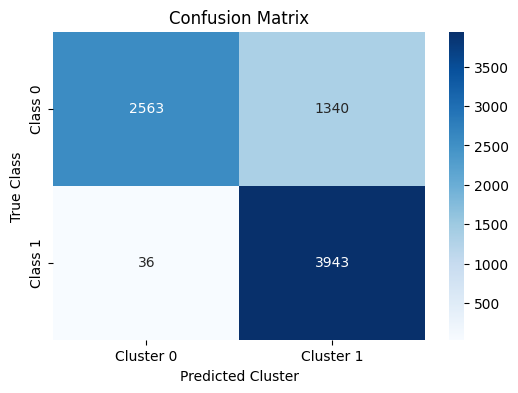

In [3]:
# Perform clustering using K-means
print("\nClustering using K-means...")
kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
kmeans.fit(tfidf)
print("K-means clustering completed!")

# Get the clustering labels
cluster_labels = kmeans.labels_
print("Clustering labels:", cluster_labels[:10])  # Print the clustering labels of the first 10 samples
print("True labels:", binary_labels[:10])  # Print the true labels of the first 10 samples

# Generate the contingency table
print("\nGenerating contingency table...")
contingency_table = confusion_matrix(binary_labels, cluster_labels)
print("Contingency table generated!")
print("Contingency table:")
print(contingency_table)

# The contingency table is not necessarily square; its shape is (true categories × clusters)
print("Contingency table shape:", contingency_table.shape)

# Generate confusion matrix
conf_matrix = confusion_matrix(binary_labels, cluster_labels)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Cluster 0', 'Cluster 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Cluster')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()


## QUESTION 3: Report the 5 clustering measures explained in the introduction for K-means clustering

In [4]:
# Calculate clustering metrics
print("\nCalculating clustering metrics...")

# Calculate five metrics
ari = adjusted_rand_score(binary_labels, cluster_labels)
nmi = normalized_mutual_info_score(binary_labels, cluster_labels)
homogeneity = homogeneity_score(binary_labels, cluster_labels)
completeness = completeness_score(binary_labels, cluster_labels)
v_measure = v_measure_score(binary_labels, cluster_labels)

print("Clustering metrics calculation completed!")

# Report clustering metrics
print("\nClustering metrics results:")
print("Adjusted Rand Index (ARI):", ari)
print("Normalized Mutual Information (NMI):", nmi)
print("Homogeneity:", homogeneity)
print("Completeness:", completeness)
print("V-Measure:", v_measure)



Calculating clustering metrics...
Clustering metrics calculation completed!

Clustering metrics results:
Adjusted Rand Index (ARI): 0.4235348988973707
Normalized Mutual Information (NMI): 0.4362142897362819
Homogeneity: 0.41761421534460047
Completeness: 0.45654845188009097
V-Measure: 0.43621428973628196


# Question 4: Plot the cumulative explained variance ratio for the first 1000 components

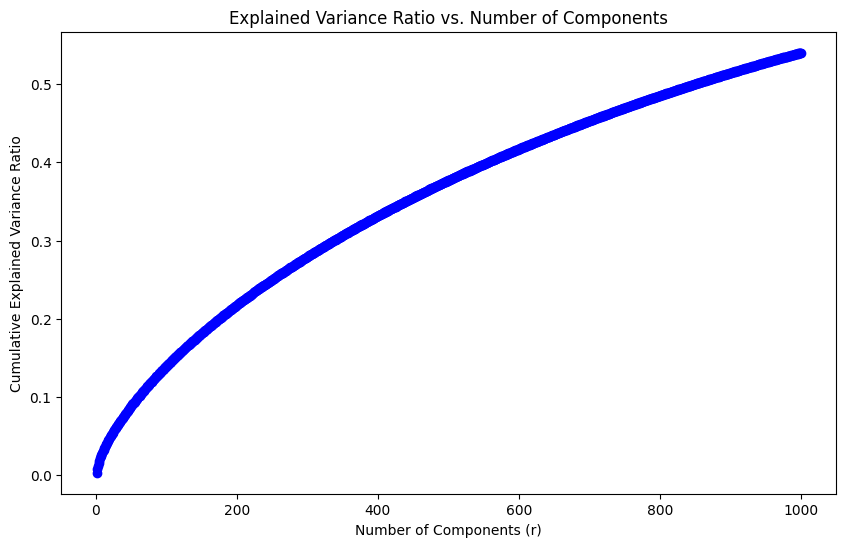

In [9]:
# Use TruncatedSVD to calculate the explained variance ratio for the first 1000 components
svd = TruncatedSVD(n_components=1000, random_state=0)
svd.fit(tfidf)

# Calculate the cumulative explained variance ratio
explained_variance_ratio = svd.explained_variance_ratio_.cumsum()

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, 1001), explained_variance_ratio, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Components (r)')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
# plt.grid(True)
plt.show()


# Question 5-7: Comparing clustering metrics for SVD and NMF with different dimensions (r)

In [10]:
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import (
    homogeneity_score,
    completeness_score,
    v_measure_score,
    adjusted_rand_score,
    adjusted_mutual_info_score
)
import matplotlib.pyplot as plt
import numpy as np

# R Values (using log-spaced values for better visualization)
r_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]

# Initialize lists to store all metrics for both methods
metrics = {
    'svd': {
        'homogeneity': [],
        'completeness': [],
        'v_measure': [],
        'ari': [],
        'nmi': []
    },
    'nmf': {
        'homogeneity': [],
        'completeness': [],
        'v_measure': [],
        'ari': [],
        'nmi': []
    }
}

# Convert binary labels (assuming you have newsgroups.target)
binary_labels = [0 if label < 4 else 1 for label in newsgroups.target]

# Process each r value
for r in r_values:
    print(f'Processing r = {r}')
    
    # SVD reduction
    svd = TruncatedSVD(n_components=r, random_state=42)
    svd_data = svd.fit_transform(tfidf)
    
    # K-means Clustering with SVD
    kmeans_svd = KMeans(n_clusters=2, random_state=42, max_iter=1000, n_init=30)
    kmeans_svd.fit(svd_data)
    
    # Calculate SVD metrics
    metrics['svd']['homogeneity'].append(homogeneity_score(binary_labels, kmeans_svd.labels_))
    metrics['svd']['completeness'].append(completeness_score(binary_labels, kmeans_svd.labels_))
    metrics['svd']['v_measure'].append(v_measure_score(binary_labels, kmeans_svd.labels_))
    metrics['svd']['ari'].append(adjusted_rand_score(binary_labels, kmeans_svd.labels_))
    metrics['svd']['nmi'].append(adjusted_mutual_info_score(binary_labels, kmeans_svd.labels_))
    
    try:
        # NMF reduction
        nmf = NMF(
            n_components=r,
            init='nndsvda',
            max_iter=1000,
            random_state=42
        )
        nmf_data = nmf.fit_transform(tfidf)
        
        # K-means Clustering with NMF
        kmeans_nmf = KMeans(n_clusters=2, random_state=42, max_iter=1000, n_init=30)
        kmeans_nmf.fit(nmf_data)
        
        # Calculate NMF metrics
        metrics['nmf']['homogeneity'].append(homogeneity_score(binary_labels, kmeans_nmf.labels_))
        metrics['nmf']['completeness'].append(completeness_score(binary_labels, kmeans_nmf.labels_))
        metrics['nmf']['v_measure'].append(v_measure_score(binary_labels, kmeans_nmf.labels_))
        metrics['nmf']['ari'].append(adjusted_rand_score(binary_labels, kmeans_nmf.labels_))
        metrics['nmf']['nmi'].append(adjusted_mutual_info_score(binary_labels, kmeans_nmf.labels_))
        
    except Exception as e:
        print(f'NMF failed for r={r}: {str(e)}')
        # Append zeros if NMF fails
        for metric in metrics['nmf']:
            metrics['nmf'][metric].append(0.0)



Processing r = 1
Processing r = 2
Processing r = 3
Processing r = 4
Processing r = 5
Processing r = 6
Processing r = 7
Processing r = 8
Processing r = 9
Processing r = 10
Processing r = 20
Processing r = 50
Processing r = 100
Processing r = 300


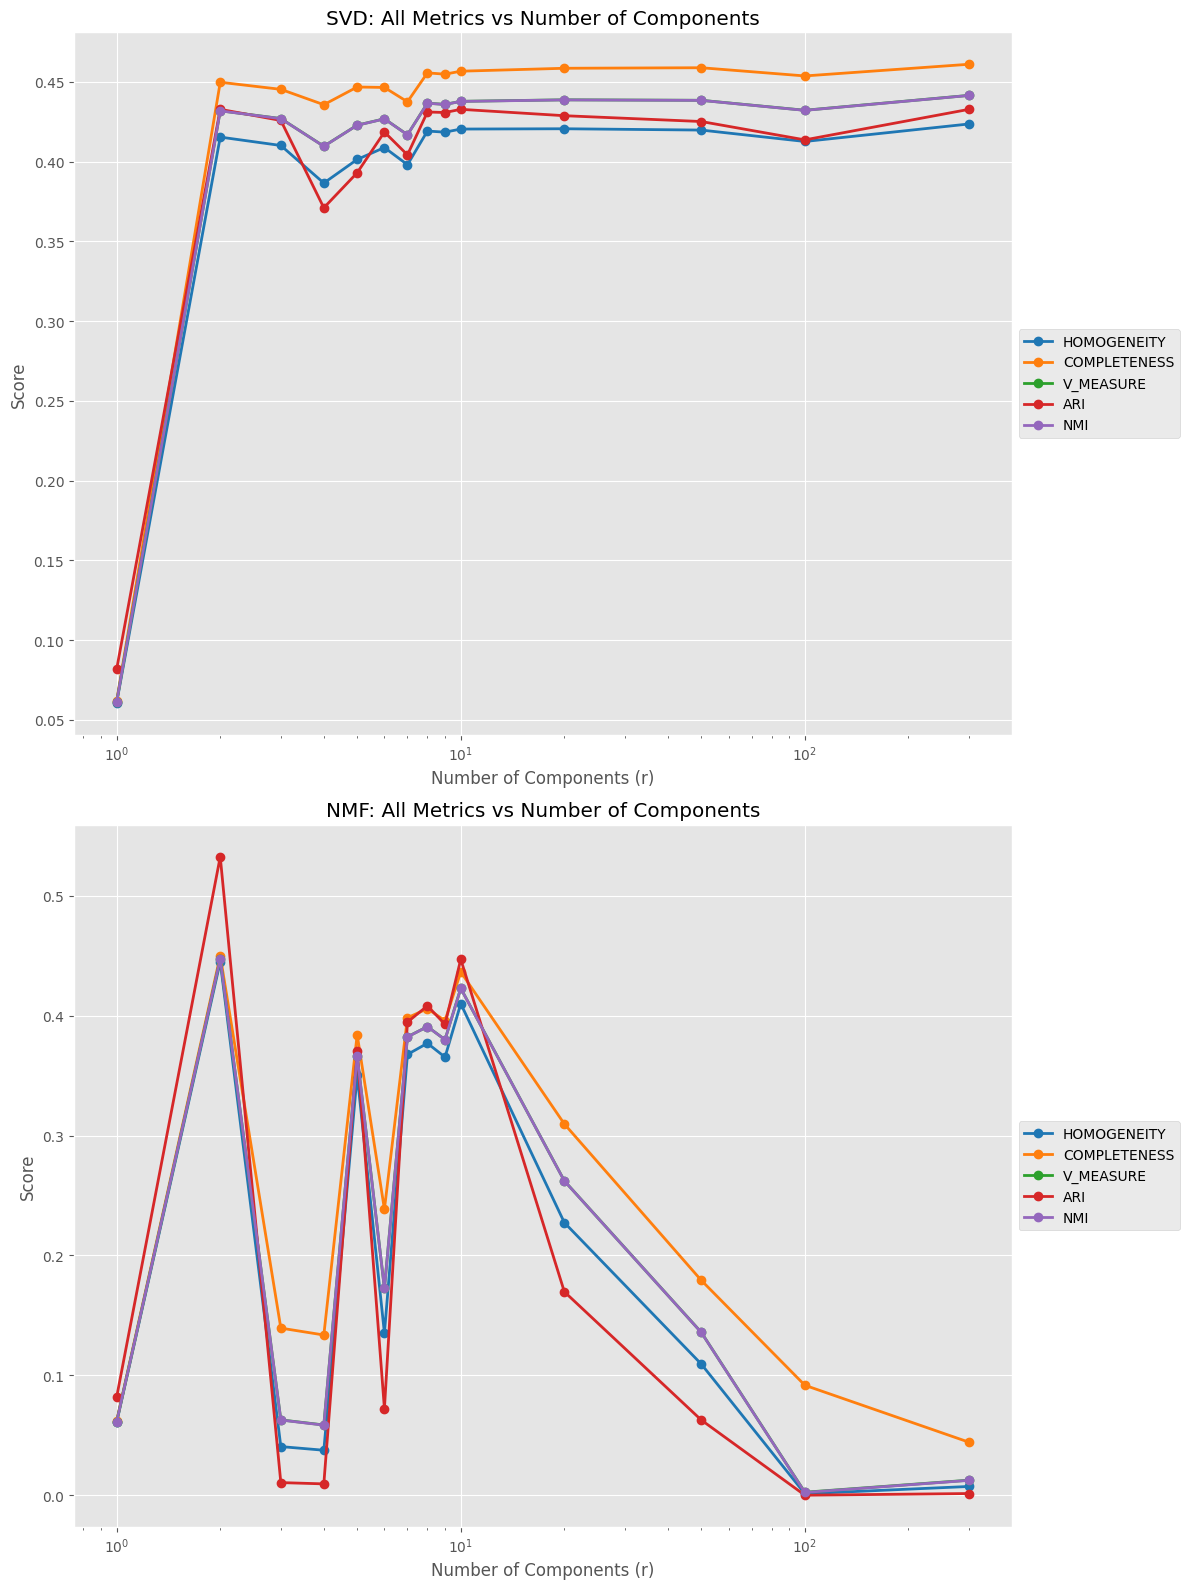


Optimal results:

SVD Results:
HOMOGENEITY  - Best r: 300, Score: 0.4237
COMPLETENESS - Best r: 300, Score: 0.4611
V_MEASURE    - Best r: 300, Score: 0.4416
ARI          - Best r: 300, Score: 0.4328
NMI          - Best r: 300, Score: 0.4415

NMF Results:
HOMOGENEITY  - Best r:   2, Score: 0.4451
COMPLETENESS - Best r:   2, Score: 0.4500
V_MEASURE    - Best r:   2, Score: 0.4475
ARI          - Best r:   2, Score: 0.5325
NMI          - Best r:   2, Score: 0.4475


In [11]:
# Plotting
plt.style.use('ggplot')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

# Colors for different metrics
colors = {
    'homogeneity': '#1f77b4',
    'completeness': '#ff7f0e',
    'v_measure': '#2ca02c',
    'ari': '#d62728',
    'nmi': '#9467bd'
}

# Plot SVD metrics
for metric, values in metrics['svd'].items():
    ax1.plot(r_values, values, marker='o', label=metric.upper(), color=colors[metric], linewidth=2)

ax1.set_xscale('log')
ax1.set_xlabel('Number of Components (r)')
ax1.set_ylabel('Score')
ax1.set_title('SVD: All Metrics vs Number of Components')
ax1.grid(True)
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Plot NMF metrics
for metric, values in metrics['nmf'].items():
    ax2.plot(r_values, values, marker='o', label=metric.upper(), color=colors[metric], linewidth=2)

ax2.set_xscale('log')
ax2.set_xlabel('Number of Components (r)')
ax2.set_ylabel('Score')
ax2.set_title('NMF: All Metrics vs Number of Components')
ax2.grid(True)
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

# Print optimal results for each metric and method
print("\nOptimal results:")
for method in ['svd', 'nmf']:
    print(f"\n{method.upper()} Results:")
    for metric in metrics[method]:
        max_score = max(metrics[method][metric])
        optimal_r = r_values[metrics[method][metric].index(max_score)]
        print(f"{metric.upper():12} - Best r: {optimal_r:3d}, Score: {max_score:.4f}")

# Question 8

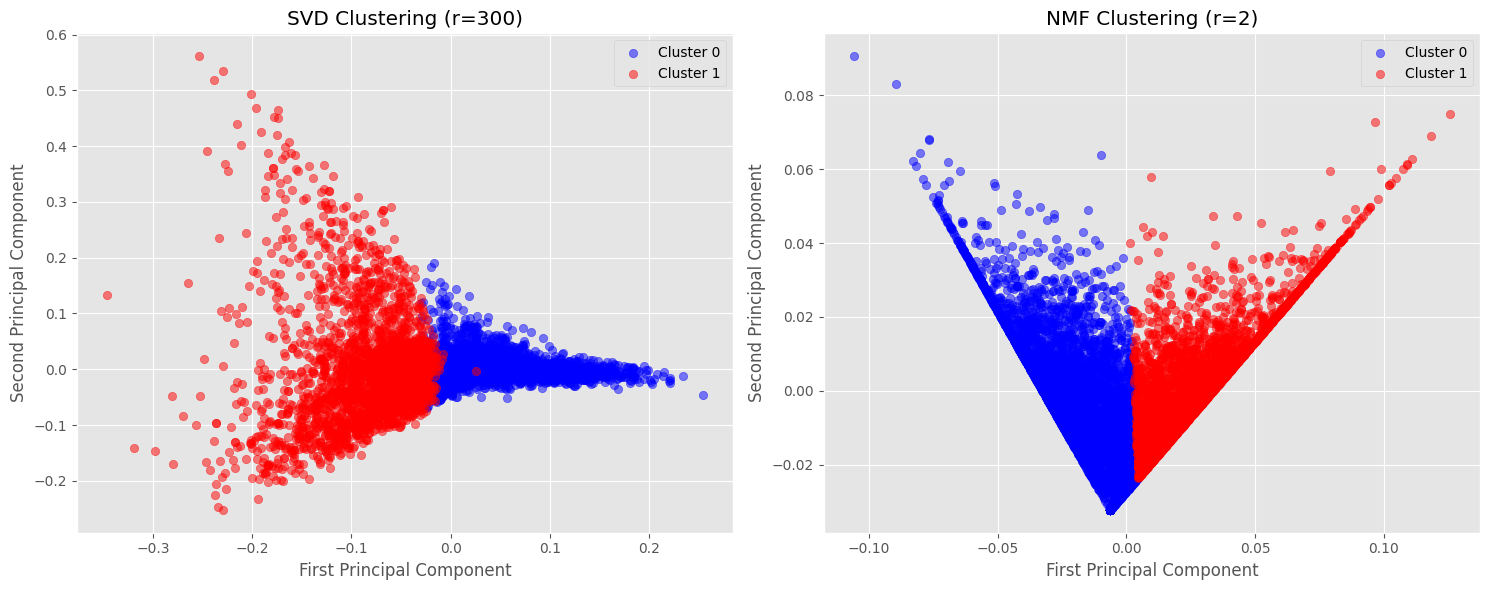

In [57]:
# For visualization, we need to project the high-dimensional data to 2D
from sklearn.decomposition import PCA

# Function to create 2D projection of data
def project_to_2d(data):
    pca = PCA(n_components=2)
    return pca.fit_transform(data)

# Create SVD representation with optimal r=300
svd_optimal = TruncatedSVD(n_components=300, random_state=42)
svd_data = svd_optimal.fit_transform(tfidf)
kmeans_svd = KMeans(n_clusters=2, random_state=42, max_iter=1000, n_init=30)
svd_labels = kmeans_svd.fit_predict(svd_data)

# Create NMF representation with optimal r=2
nmf_optimal = NMF(n_components=2, init='nndsvda', max_iter=1000, random_state=42)
nmf_data = nmf_optimal.fit_transform(tfidf)
kmeans_nmf = KMeans(n_clusters=2, random_state=42, max_iter=1000, n_init=30)
nmf_labels = kmeans_nmf.fit_predict(nmf_data)

# Project the data to 2D for visualization
svd_2d = project_to_2d(svd_data)
nmf_2d = project_to_2d(nmf_data)

# Create scatter plots
plt.figure(figsize=(15, 6))

# SVD plot
plt.subplot(121)
plt.scatter(svd_2d[svd_labels == 0, 0], svd_2d[svd_labels == 0, 1], 
           c='blue', label='Cluster 0', alpha=0.5)
plt.scatter(svd_2d[svd_labels == 1, 0], svd_2d[svd_labels == 1, 1], 
           c='red', label='Cluster 1', alpha=0.5)
plt.title('SVD Clustering (r=300)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()

# NMF plot
plt.subplot(122)
plt.scatter(nmf_2d[nmf_labels == 0, 0], nmf_2d[nmf_labels == 0, 1], 
           c='blue', label='Cluster 0', alpha=0.5)
plt.scatter(nmf_2d[nmf_labels == 1, 0], nmf_2d[nmf_labels == 1, 1], 
           c='red', label='Cluster 1', alpha=0.5)
plt.title('NMF Clustering (r=2)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()

plt.tight_layout()
plt.show()

# Q10

/root/miniconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Clustering Metrics for SVD:
Homogeneity Score: 0.25762380069949004
Completeness Score: 0.2930943066505179
V-measure Score: 0.2742167662001323
Adjusted Rand Index: 0.08220070867454365
Adjusted Mutual Info Score: 0.27170661646480215

Clustering Metrics for NMF:
Homogeneity Score: 0.2562941261665178
Completeness Score: 0.297306107908675
V-measure Score: 0.2752809859544703
Adjusted Rand Index: 0.07803155758473546
Adjusted Mutual Info Score: 0.2727491111160067


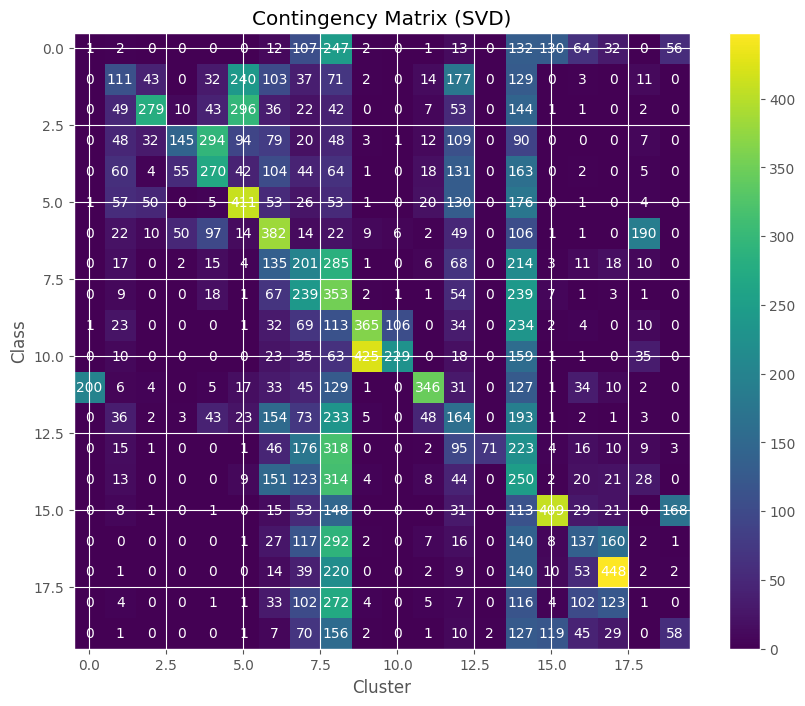

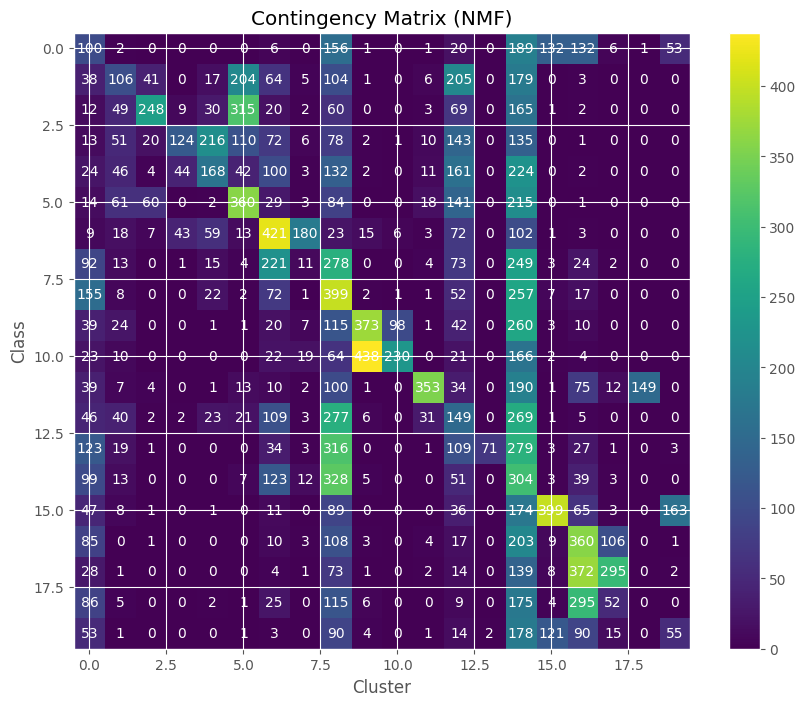

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Load documents for all 20 categories
newsgroups_data = fetch_20newsgroups(subset='all', random_state = 0, 
                                     remove = ('headers', 'footers', 'quotes'))

# Convert documents to TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', min_df = 3)
tfidf_vectors = tfidf_vectorizer.fit_transform(newsgroups_data.data)

# Define the number of clusters
n_clusters = 20

# Define the best r values
best_r_svd = 9
best_r_nmf = 10

# Reduce dimensionality using Truncated SVD (PCA) with the best r value
svd = TruncatedSVD(n_components = best_r_svd, random_state = 0)
svd_data = svd.fit_transform(tfidf_vectors)

# Reduce dimensionality using NMF with the best r value
nmf = NMF(n_components = best_r_nmf, random_state = 0)
nmf_data = nmf.fit_transform(tfidf_vectors)

# Perform K-Means clustering with k=20 for both SVD and NMF
kmeans_svd = KMeans(n_clusters = n_clusters, random_state = 0, max_iter = 1000, n_init = 30)
kmeans_nmf = KMeans(n_clusters = n_clusters, random_state = 0, max_iter = 1000, n_init = 30)

# Fit K-Means to the dimension-reduced data
kmeans_svd.fit(svd_data)
kmeans_nmf.fit(nmf_data)

# Calculate clustering metrics for SVD
svd_homogeneity = homogeneity_score(newsgroups_data.target, kmeans_svd.labels_)
svd_completeness = completeness_score(newsgroups_data.target, kmeans_svd.labels_)
svd_v_measure = v_measure_score(newsgroups_data.target, kmeans_svd.labels_)
svd_ari = adjusted_rand_score(newsgroups_data.target, kmeans_svd.labels_)
svd_ami = adjusted_mutual_info_score(newsgroups_data.target, kmeans_svd.labels_)

# Calculate clustering metrics for NMF
nmf_homogeneity = homogeneity_score(newsgroups_data.target, kmeans_nmf.labels_)
nmf_completeness = completeness_score(newsgroups_data.target, kmeans_nmf.labels_)
nmf_v_measure = v_measure_score(newsgroups_data.target, kmeans_nmf.labels_)
nmf_ari = adjusted_rand_score(newsgroups_data.target, kmeans_nmf.labels_)
nmf_ami = adjusted_mutual_info_score(newsgroups_data.target, kmeans_nmf.labels_)

# Print clustering metrics for SVD
print("Clustering Metrics for SVD:")
print("Homogeneity Score:", svd_homogeneity)
print("Completeness Score:", svd_completeness)
print("V-measure Score:", svd_v_measure)
print("Adjusted Rand Index:", svd_ari)
print("Adjusted Mutual Info Score:", svd_ami)

# Print clustering metrics for NMF
print("\nClustering Metrics for NMF:")
print("Homogeneity Score:", nmf_homogeneity)
print("Completeness Score:", nmf_completeness)
print("V-measure Score:", nmf_v_measure)
print("Adjusted Rand Index:", nmf_ari)
print("Adjusted Mutual Info Score:", nmf_ami)

# Calculate contingency matrix for SVD
cm_svd = confusion_matrix(newsgroups_data.target, kmeans_svd.labels_)

# Calculate contingency matrix for NMF
cm_nmf = confusion_matrix(newsgroups_data.target, kmeans_nmf.labels_)

# Reorder the contingency matrix for SVD
rows_svd, cols_svd = linear_sum_assignment(cm_svd, maximize = True)
cm_svd_reordered = cm_svd[rows_svd[:, np.newaxis], cols_svd]

# Reorder the contingency matrix for NMF
rows_nmf, cols_nmf = linear_sum_assignment(cm_nmf, maximize = True)
cm_nmf_reordered = cm_nmf[rows_nmf[:, np.newaxis], cols_nmf]


# Plot contingency matrix for SVD
plt.figure(figsize=(10, 8))
plt.imshow(cm_svd_reordered, interpolation = 'nearest', cmap = 'viridis')
plt.title('Contingency Matrix (SVD)')
plt.colorbar()
plt.xlabel('Cluster')
plt.ylabel('Class')

# Display numbers within the matrix
for i in range(cm_svd_reordered.shape[0]):
    for j in range(cm_svd_reordered.shape[1]):
        plt.text(j, i, cm_svd_reordered[i, j], ha = 'center', va = 'center', color = 'white')

plt.show()

# Plot contingency matrix for NMF
plt.figure(figsize=(10, 8))
plt.imshow(cm_nmf_reordered, interpolation = 'nearest', cmap = 'viridis')
plt.title('Contingency Matrix (NMF)')
plt.colorbar()
plt.xlabel('Cluster')
plt.ylabel('Class')

# Display numbers within the matrix
for i in range(cm_nmf_reordered.shape[0]):
    for j in range(cm_nmf_reordered.shape[1]):
        plt.text(j, i, cm_nmf_reordered[i, j], ha = 'center', va = 'center', color = 'white')

plt.show()

# Q11-13


Processing UMAP(n=5, metric=cosine)


/root/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/root/miniconda3/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


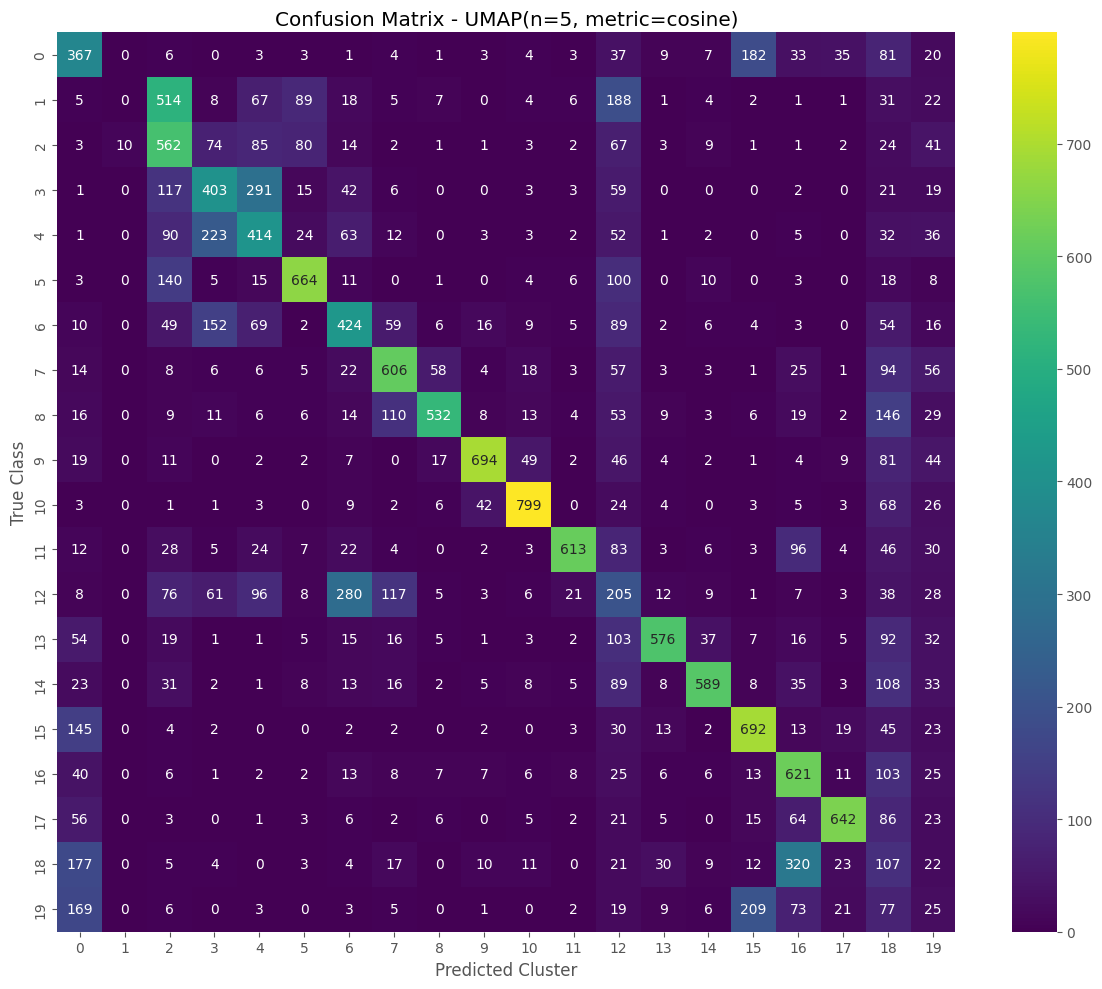


Metrics for UMAP(n=5, metric=cosine):
Homogeneity: 0.4573
Completeness: 0.4705
V-measure: 0.4638
ARI: 0.3155
AMI: 0.4620

Processing UMAP(n=5, metric=euclidean)


/root/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


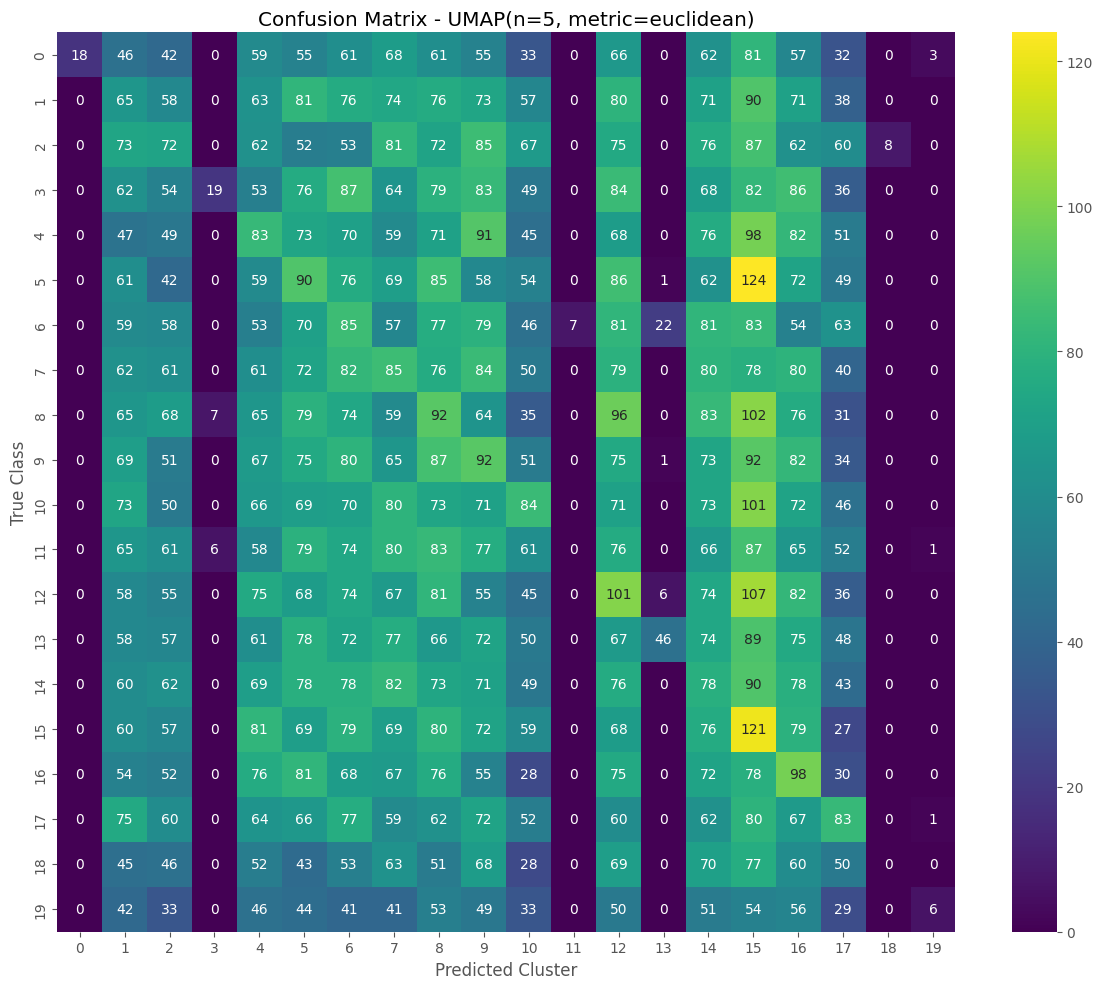


Metrics for UMAP(n=5, metric=euclidean):
Homogeneity: 0.0092
Completeness: 0.0103
V-measure: 0.0097
ARI: 0.0005
AMI: 0.0063

Processing UMAP(n=20, metric=cosine)


/root/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


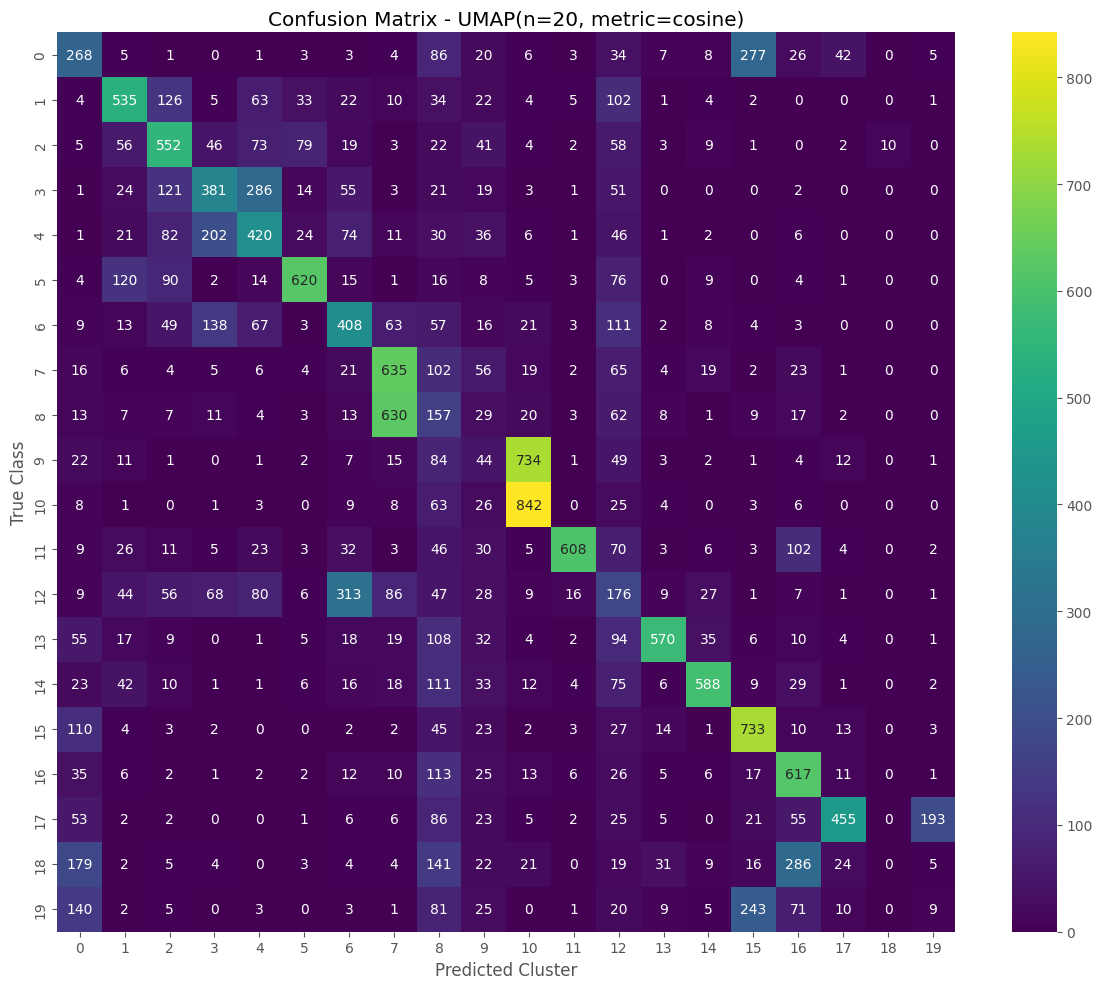


Metrics for UMAP(n=20, metric=cosine):
Homogeneity: 0.4433
Completeness: 0.4614
V-measure: 0.4522
ARI: 0.3052
AMI: 0.4504

Processing UMAP(n=20, metric=euclidean)


/root/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


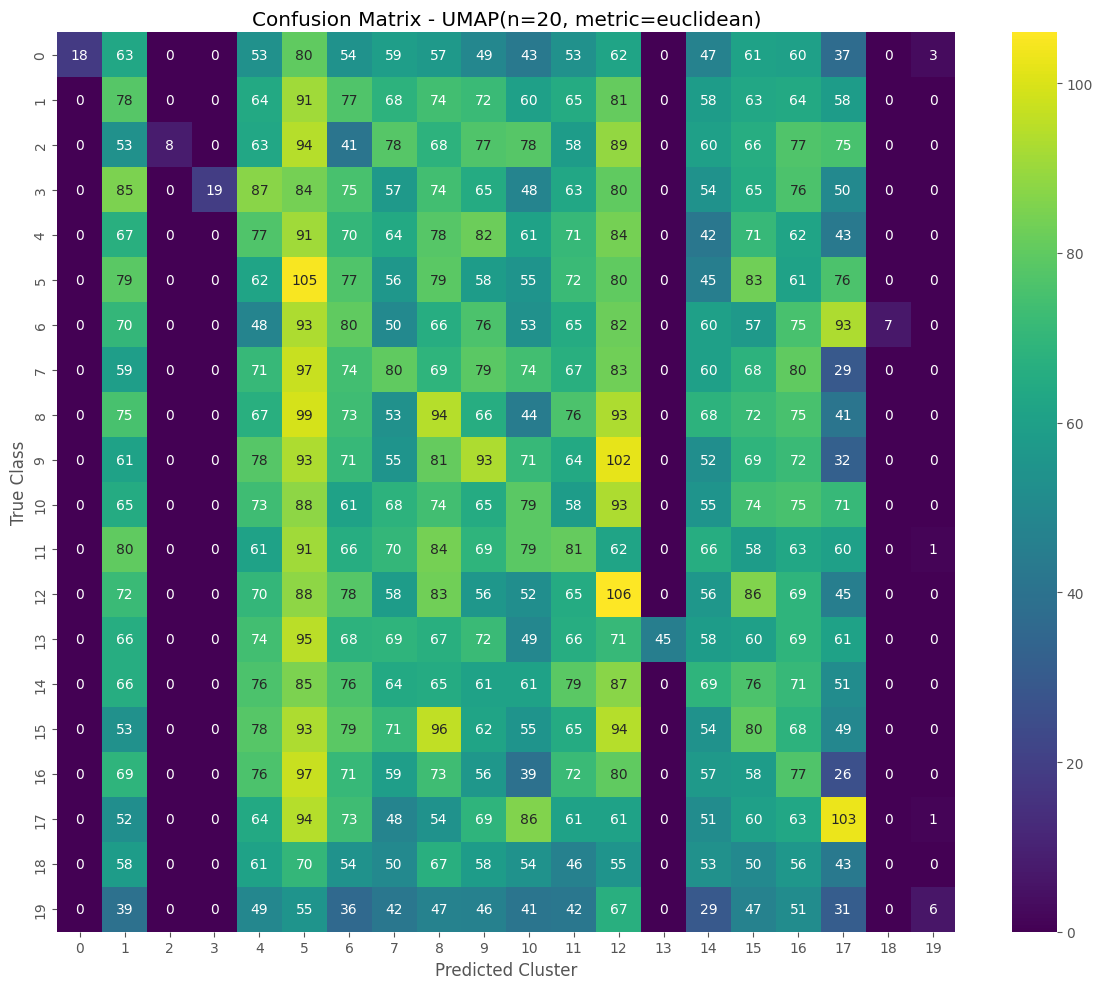


Metrics for UMAP(n=20, metric=euclidean):
Homogeneity: 0.0093
Completeness: 0.0104
V-measure: 0.0098
ARI: 0.0006
AMI: 0.0064

Processing UMAP(n=200, metric=cosine)


/root/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


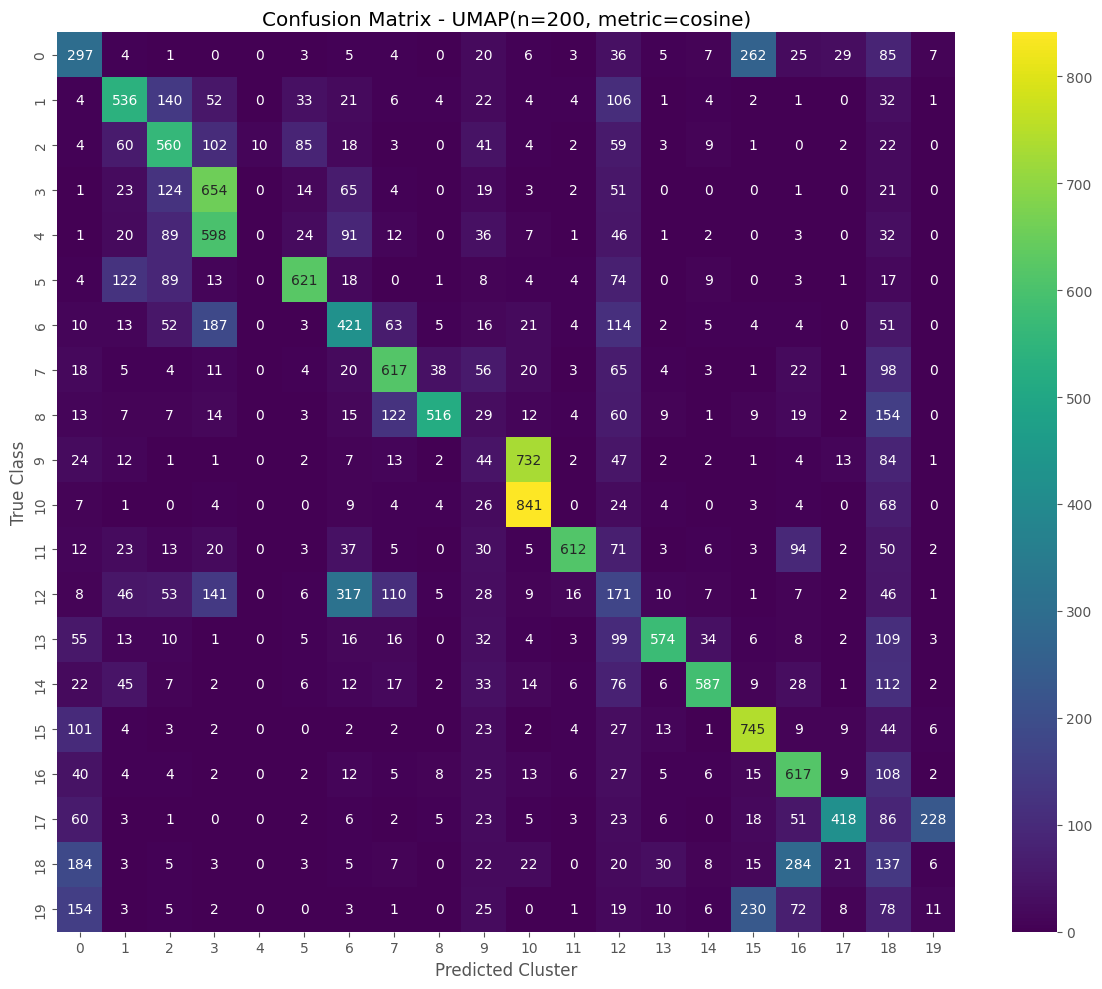


Metrics for UMAP(n=200, metric=cosine):
Homogeneity: 0.4540
Completeness: 0.4742
V-measure: 0.4639
ARI: 0.3147
AMI: 0.4621

Processing UMAP(n=200, metric=euclidean)


/root/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


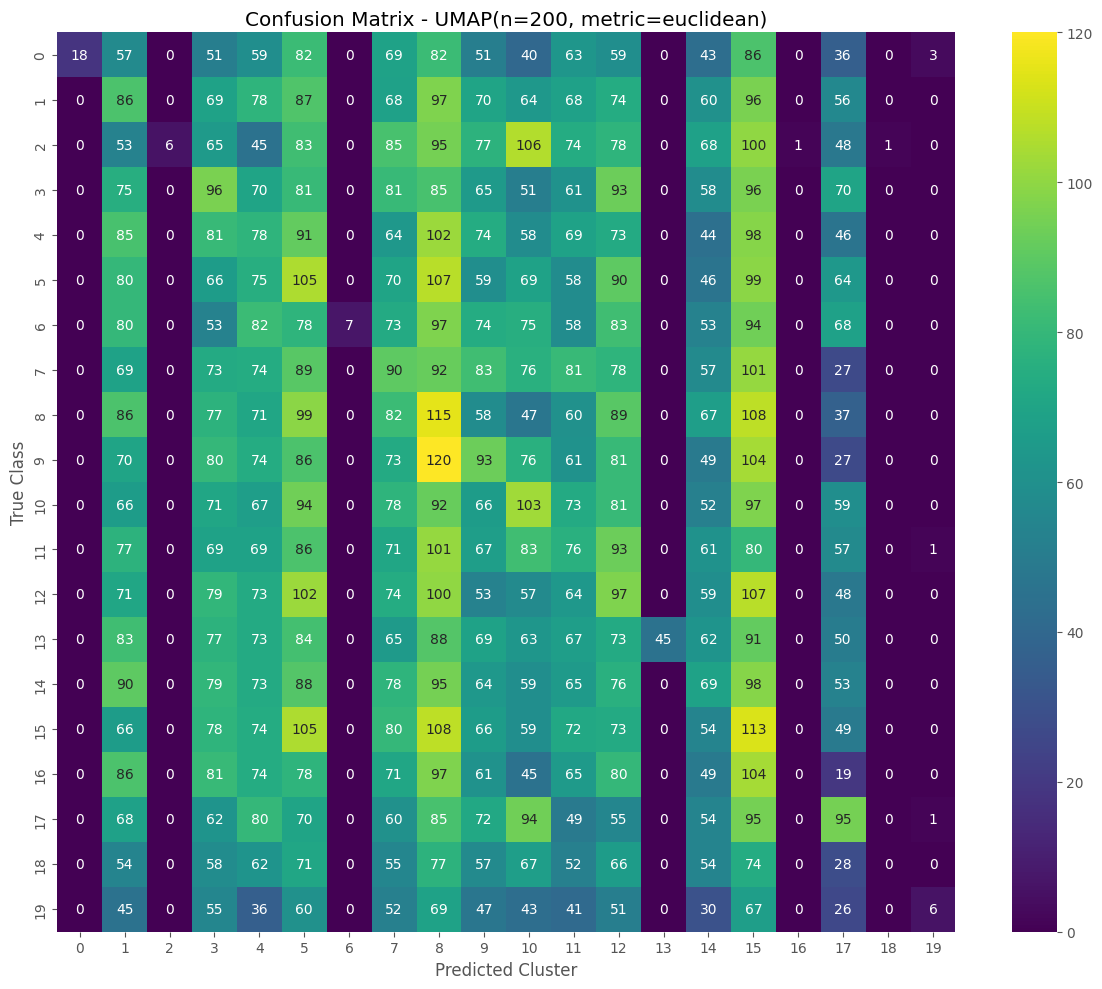


Metrics for UMAP(n=200, metric=euclidean):
Homogeneity: 0.0080
Completeness: 0.0093
V-measure: 0.0086
ARI: 0.0005
AMI: 0.0054

Processing Raw TF-IDF

Processing PCA

Processing NMF


In [13]:
from scipy.optimize import linear_sum_assignment

# Load and preprocess data
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
vectorizer = TfidfVectorizer(stop_words='english', min_df=3)
tfidf_matrix = vectorizer.fit_transform(newsgroups.data)

def perform_clustering_analysis(data, true_labels, method_name):
    """Perform K-means clustering and calculate metrics"""
    kmeans = KMeans(n_clusters=20, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(data)
    
    # Calculate metrics
    metrics = {
        'Homogeneity': homogeneity_score(true_labels, cluster_labels),
        'Completeness': completeness_score(true_labels, cluster_labels),
        'V-measure': v_measure_score(true_labels, cluster_labels),
        'ARI': adjusted_rand_score(true_labels, cluster_labels),
        'AMI': adjusted_mutual_info_score(true_labels, cluster_labels)
    }
    
    # Calculate and optimize confusion matrix
    cm = confusion_matrix(true_labels, cluster_labels)
    row_ind, col_ind = linear_sum_assignment(cm, maximize=True)
    cm_optimized = cm[row_ind[:, np.newaxis], col_ind]
    
    return metrics, cm_optimized

def plot_confusion_matrix(cm, title):
    """Plot confusion matrix with improved visibility"""
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, cmap='viridis', annot=True, fmt='d', cbar=True)
    plt.title(title)
    plt.xlabel('Predicted Cluster')
    plt.ylabel('True Class')
    plt.tight_layout()
    plt.show()

# UMAP Analysis (Question 11)
n_components_list = [5, 20, 200]
metrics_list = ['cosine', 'euclidean']
results = {}

for n_comp in n_components_list:
    for metric in metrics_list:
        method_name = f'UMAP(n={n_comp}, metric={metric})'
        print(f"\nProcessing {method_name}")
        
        # UMAP reduction
        reducer = umap.UMAP(n_components=n_comp, metric=metric, random_state=42)
        umap_embedding = reducer.fit_transform(tfidf_matrix)
        
        # Perform clustering and get results
        metrics, cm = perform_clustering_analysis(umap_embedding, newsgroups.target, method_name)
        results[method_name] = {'metrics': metrics, 'cm': cm}
        
        # Plot confusion matrix
        plot_confusion_matrix(cm, f'Confusion Matrix - {method_name}')
        
        # Print metrics
        print(f"\nMetrics for {method_name}:")
        for metric_name, value in metrics.items():
            print(f"{metric_name}: {value:.4f}")

# Baseline methods for comparison (Question 13)
# Raw TF-IDF
print("\nProcessing Raw TF-IDF")
tfidf_metrics, tfidf_cm = perform_clustering_analysis(tfidf_matrix.toarray(), 
                                                    newsgroups.target, 'Raw TF-IDF')
results['Raw TF-IDF'] = {'metrics': tfidf_metrics, 'cm': tfidf_cm}

# PCA (SVD)
print("\nProcessing PCA")
svd = TruncatedSVD(n_components=100, random_state=42)
svd_reduced = svd.fit_transform(tfidf_matrix)
svd_metrics, svd_cm = perform_clustering_analysis(svd_reduced, 
                                                newsgroups.target, 'PCA')
results['PCA'] = {'metrics': svd_metrics, 'cm': svd_cm}

# NMF
print("\nProcessing NMF")
nmf = NMF(n_components=100, random_state=42)
nmf_reduced = nmf.fit_transform(tfidf_matrix)
nmf_metrics, nmf_cm = perform_clustering_analysis(nmf_reduced, 
                                                newsgroups.target, 'NMF')
results['NMF'] = {'metrics': nmf_metrics, 'cm': nmf_cm}



In [15]:
metrics_df = pd.DataFrame({method: result['metrics'] 
                          for method, result in results.items()}).T

# Print final comparison table
print("\nFinal Comparison of All Methods:")
print(metrics_df.round(4).to_string())


Final Comparison of All Methods:
                               Homogeneity  Completeness  V-measure     ARI     AMI
UMAP(n=5, metric=cosine)            0.4573        0.4705     0.4638  0.3155  0.4620
UMAP(n=5, metric=euclidean)         0.0092        0.0103     0.0097  0.0005  0.0063
UMAP(n=20, metric=cosine)           0.4433        0.4614     0.4522  0.3052  0.4504
UMAP(n=20, metric=euclidean)        0.0093        0.0104     0.0098  0.0006  0.0064
UMAP(n=200, metric=cosine)          0.4540        0.4742     0.4639  0.3147  0.4621
UMAP(n=200, metric=euclidean)       0.0080        0.0093     0.0086  0.0005  0.0054
Raw TF-IDF                          0.2939        0.3675     0.3266  0.0696  0.3242
PCA                                 0.2653        0.3392     0.2978  0.0636  0.2952
NMF                                 0.0869        0.1697     0.1149  0.0079  0.1110


# Question 14: Agglomerative Clustering


Agglomerative Clustering with ward linkage:
Homogeneity: 0.4455
Completeness: 0.4663
V-measure: 0.4556
ARI: 0.3025
AMI: 0.4538


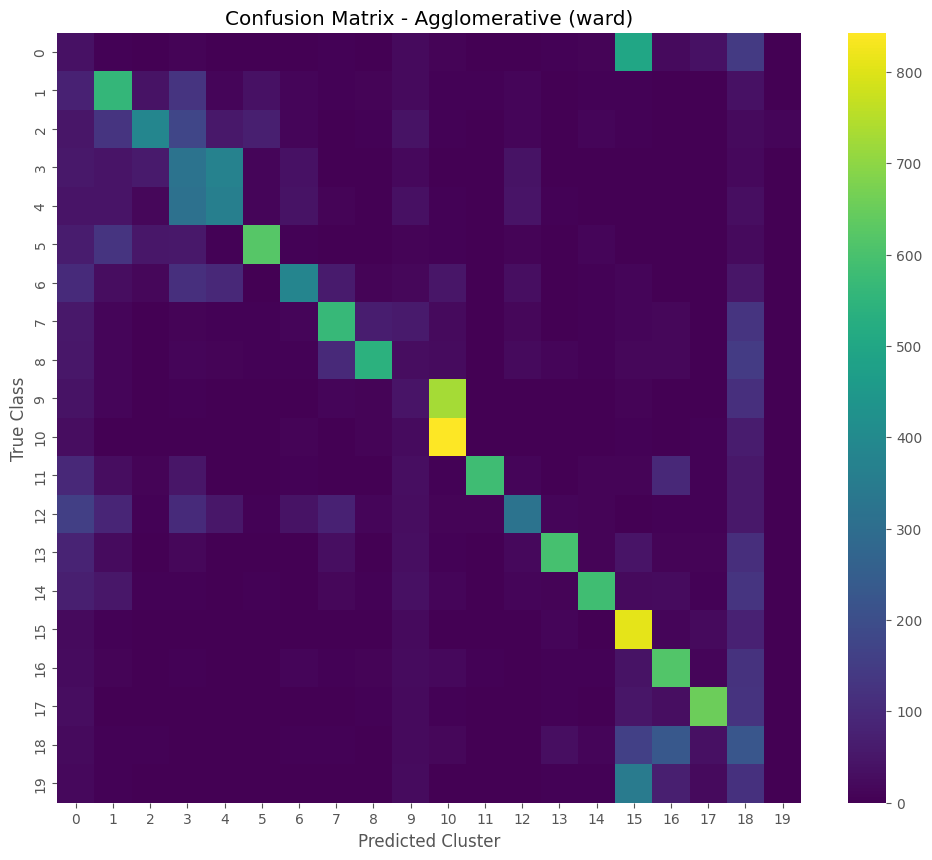


Agglomerative Clustering with single linkage:
Homogeneity: 0.0111
Completeness: 0.1384
V-measure: 0.0206
ARI: 0.0001
AMI: 0.0150


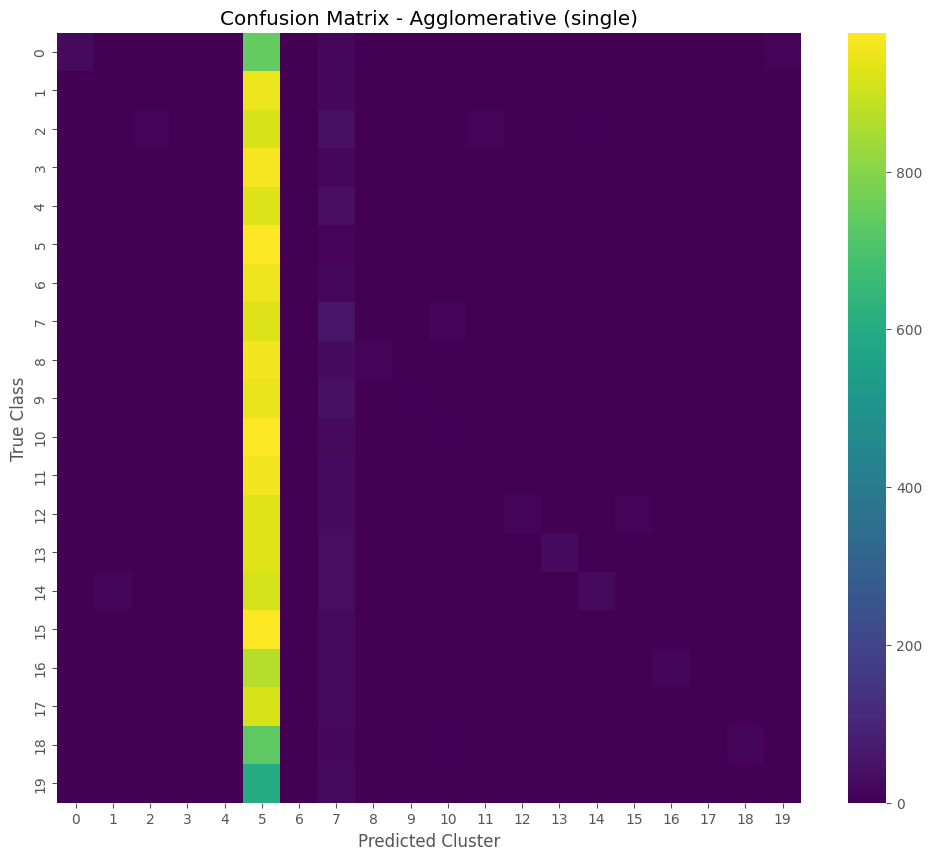

In [17]:
from sklearn.cluster import AgglomerativeClustering
from scipy.optimize import linear_sum_assignment

# UMAP reduction
reducer = umap.UMAP(n_components=5, metric='cosine', random_state=42)
umap_embedding = reducer.fit_transform(tfidf_matrix)


linkages = ['ward', 'single']
for linkage in linkages:
    print(f"\nAgglomerative Clustering with {linkage} linkage:")
    clustering = AgglomerativeClustering(n_clusters=20, linkage=linkage)
    labels = clustering.fit_predict(umap_embedding)
    
    # Calculate and print metrics
    print(f"Homogeneity: {homogeneity_score(newsgroups.target, labels):.4f}")
    print(f"Completeness: {completeness_score(newsgroups.target, labels):.4f}")
    print(f"V-measure: {v_measure_score(newsgroups.target, labels):.4f}")
    print(f"ARI: {adjusted_rand_score(newsgroups.target, labels):.4f}")
    print(f"AMI: {adjusted_mutual_info_score(newsgroups.target, labels):.4f}")
    
    # Plot confusion matrix
    cm = confusion_matrix(newsgroups.target, labels)
    rows, cols = linear_sum_assignment(cm, maximize=True)
    cm_optimized = cm[rows[:, np.newaxis], cols]
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_optimized, cmap='viridis', annot=False)
    plt.title(f'Confusion Matrix - Agglomerative ({linkage})')
    plt.xlabel('Predicted Cluster')
    plt.ylabel('True Class')
    plt.show()

# Question 15: HDBSCAN Analysis

In [28]:
# Load dataset and preprocess
newsgroups_data = fetch_20newsgroups(subset='all', random_state=0)
tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=3)
tfidf_vectors = tfidf_vectorizer.fit_transform(newsgroups_data.data)

# UMAP dimensionality reduction
umap_reducer = umap.UMAP(n_components=2, random_state=0)
umap_data = umap_reducer.fit_transform(tfidf_vectors)

# Store results
results = []
min_cluster_sizes = [20, 100, 200]

# Clustering and evaluation
for min_size in min_cluster_sizes:
    hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=min_size)
    cluster_labels = hdbscan_clusterer.fit_predict(umap_data)
    
    # Calculate metrics
    metrics = {
        'min_cluster_size': min_size,
        'homogeneity': homogeneity_score(newsgroups_data.target, cluster_labels),
        'completeness': completeness_score(newsgroups_data.target, cluster_labels),
        'v_measure': v_measure_score(newsgroups_data.target, cluster_labels),
        'adjusted_rand': adjusted_rand_score(newsgroups_data.target, cluster_labels),
        'adjusted_mutual_info': adjusted_mutual_info_score(newsgroups_data.target, cluster_labels),
        'num_clusters': len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0),
        'noise_points': np.sum(cluster_labels == -1)
    }
    results.append(metrics)
    
    # Print results
    print(f"\nResults for min_cluster_size = {min_size}:")
    for key, value in metrics.items():
        if key != 'min_cluster_size':
            print(f"{key}: {value:.4f}")

/root/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/root/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Results for min_cluster_size = 20:
homogeneity: 0.4273
completeness: 0.3712
v_measure: 0.3973
adjusted_rand: 0.0592
adjusted_mutual_info: 0.3792
num_clusters: 166.0000
noise_points: 7502.0000


/root/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Results for min_cluster_size = 100:
homogeneity: 0.3650
completeness: 0.5600
v_measure: 0.4419
adjusted_rand: 0.1589
adjusted_mutual_info: 0.4407
num_clusters: 11.0000
noise_points: 3410.0000


/root/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Results for min_cluster_size = 200:
homogeneity: 0.0131
completeness: 0.4302
v_measure: 0.0255
adjusted_rand: 0.0005
adjusted_mutual_info: 0.0248
num_clusters: 2.0000
noise_points: 84.0000


# Question 16: Best Model Analysis

/root/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


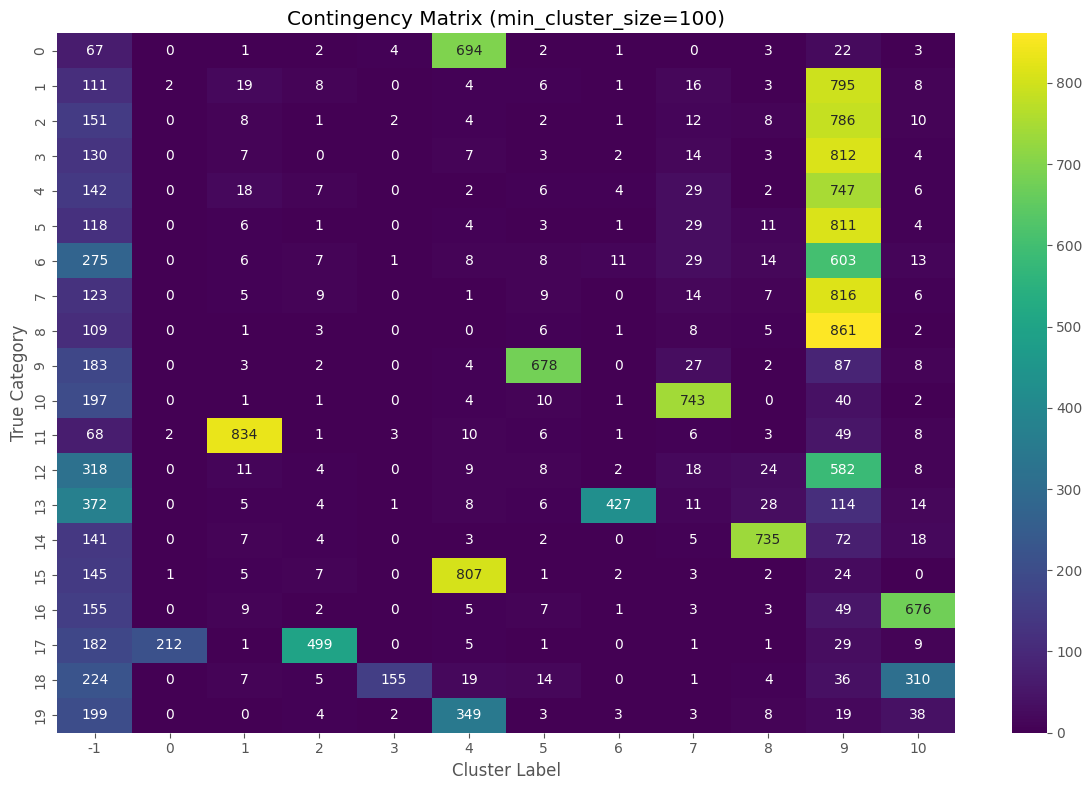

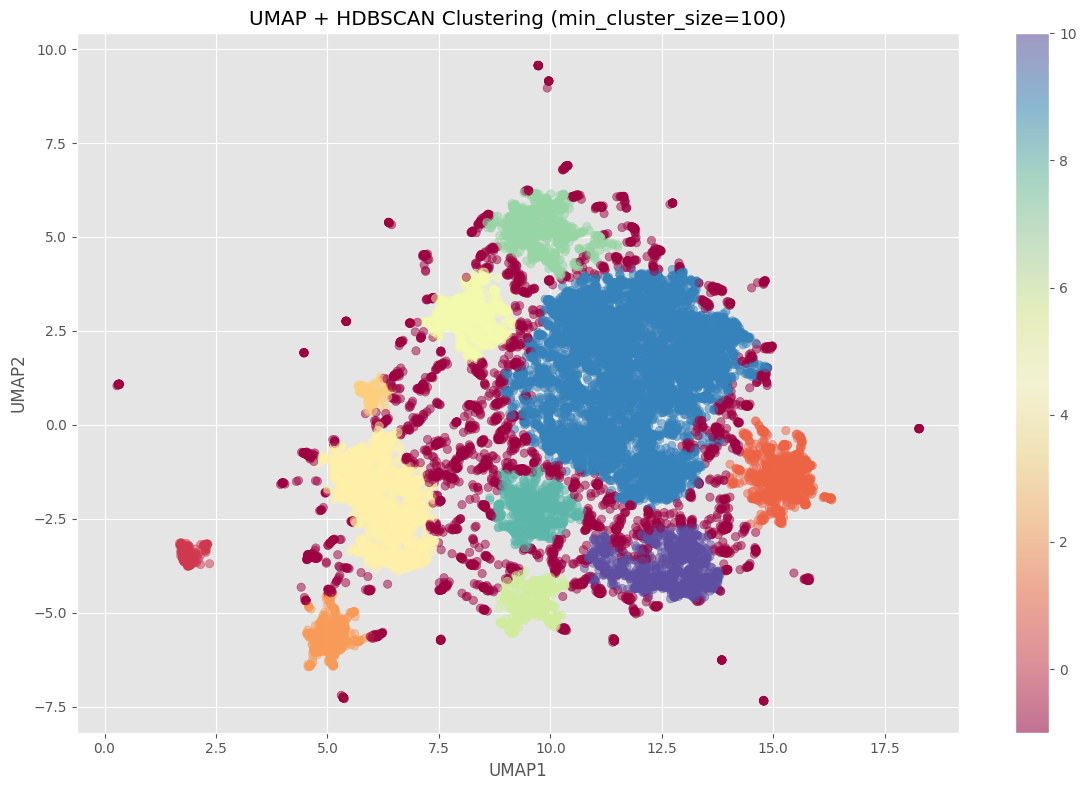


Final Clustering Statistics:
Number of clusters: 11
Noise points: 3410
Noise percentage: 18.09%


In [30]:
# Create contingency matrix visualization
best_result_idx = np.argmax([r['completeness'] for r in results])
best_min_size = min_cluster_sizes[best_result_idx]

final_clusterer = hdbscan.HDBSCAN(min_cluster_size=best_min_size)
final_labels = final_clusterer.fit_predict(umap_data)

# Plot contingency matrix
plt.figure(figsize=(12, 8))
contingency = pd.crosstab(newsgroups_data.target, final_labels)
sns.heatmap(contingency, annot=True, fmt='d', cmap='viridis')
plt.title(f'Contingency Matrix (min_cluster_size={best_min_size})')
plt.xlabel('Cluster Label')
plt.ylabel('True Category')
plt.tight_layout()
plt.show()

# Scatter plot of UMAP results
plt.figure(figsize=(12, 8))
scatter = plt.scatter(umap_data[:, 0], umap_data[:, 1], 
                     c=final_labels, cmap='Spectral',
                     alpha=0.5)
plt.colorbar(scatter)
plt.title(f'UMAP + HDBSCAN Clustering (min_cluster_size={best_min_size})')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.tight_layout()
plt.show()

# Print final statistics
print("\nFinal Clustering Statistics:")
print(f"Number of clusters: {results[best_result_idx]['num_clusters']}")
print(f"Noise points: {results[best_result_idx]['noise_points']}")
print(f"Noise percentage: {results[best_result_idx]['noise_points']/len(final_labels)*100:.2f}%")

# Question17  （该部分改为整合之前的代码结果，而不是重新跑，太过于耗时）

# Question18

## test1（测试使用，没放在报告）

In [64]:
# 改进后的完整实现
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import umap
import hdbscan
from sklearn.metrics import *
from nltk.stem import SnowballStemmer
import re
import numpy as np

# 增强数据预处理
newsgroups_data = fetch_20newsgroups(
    subset='all',
    random_state=0,
    remove=('headers', 'footers', 'quotes')  # 移除结构化噪声
)

# 自定义文本处理（词干提取+特殊字符过滤）
stemmer = SnowballStemmer("english")
def custom_processor(text):
    tokens = re.sub(r"[^a-zA-Z]", " ", text).lower().split()
    return [stemmer.stem(word) for word in tokens]

# 优化TF-IDF参数
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=custom_processor,
    stop_words='english',
    min_df=5,          # 过滤低频词
    max_df=0.85,       # 过滤高频词
    ngram_range=(1,2), # 包含二元语法
    sublinear_tf=True, # 平滑处理
    max_features=20000 # 控制特征维度
)
tfidf_vectors = tfidf_vectorizer.fit_transform(newsgroups_data.data)

# 双层降维
svd = TruncatedSVD(n_components=100, random_state=0)  # 初步降维
svd_vectors = svd.fit_transform(tfidf_vectors)

umap_reducer = umap.UMAP(
    n_components=10,   # 保留更多维度
    n_neighbors=30,    # 平衡局部/全局结构
    min_dist=0.1,
    metric='cosine',   # 适合TF-IDF
    random_state=0
)
umap_data = umap_reducer.fit_transform(svd_vectors)

# 优化聚类参数
hdbscan_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=80,
    min_samples=15,
    cluster_selection_epsilon=0.3,
    cluster_selection_method='leaf',
    core_dist_n_jobs=1  # 禁用并行计算
)
cluster_labels = hdbscan_clusterer.fit_predict(umap_data)

# 评估指标
metrics = {
    'homogeneity': homogeneity_score(newsgroups_data.target, cluster_labels),
    'completeness': completeness_score(newsgroups_data.target, cluster_labels),
    'v_measure': v_measure_score(newsgroups_data.target, cluster_labels),
    'adjusted_rand': adjusted_rand_score(newsgroups_data.target, cluster_labels),
    'adjusted_mutual_info': adjusted_mutual_info_score(newsgroups_data.target, cluster_labels),
    'num_clusters': len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0),
    'noise_points': np.sum(cluster_labels == -1)
}

print("优化后的聚类结果：")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")

/root/miniconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'ver

优化后的聚类结果：
homogeneity: 0.2979
completeness: 0.3194
v_measure: 0.3083
adjusted_rand: 0.1454
adjusted_mutual_info: 0.3041
num_clusters: 33
noise_points: 3823


## test2（测试使用，没放在报告）

Loading and preprocessing data...
Performing dimension reduction...

Testing KMeans...
Completed KMeans with params: {'algorithm': 'lloyd', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 15, 'n_init': 10, 'random_state': 42, 'tol': 0.0001, 'verbose': 0}
Completed KMeans with params: {'algorithm': 'lloyd', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 20, 'n_init': 10, 'random_state': 42, 'tol': 0.0001, 'verbose': 0}
Completed KMeans with params: {'algorithm': 'lloyd', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 25, 'n_init': 10, 'random_state': 42, 'tol': 0.0001, 'verbose': 0}

Testing Agglomerative...
Completed Agglomerative with params: {'compute_distances': False, 'compute_full_tree': 'auto', 'connectivity': None, 'distance_threshold': None, 'linkage': 'ward', 'memory': None, 'metric': 'euclidean', 'n_clusters': 20}
Completed Agglomerative with params: {'compute_distances': False, 'compute_full_tree': 'auto', 'connec

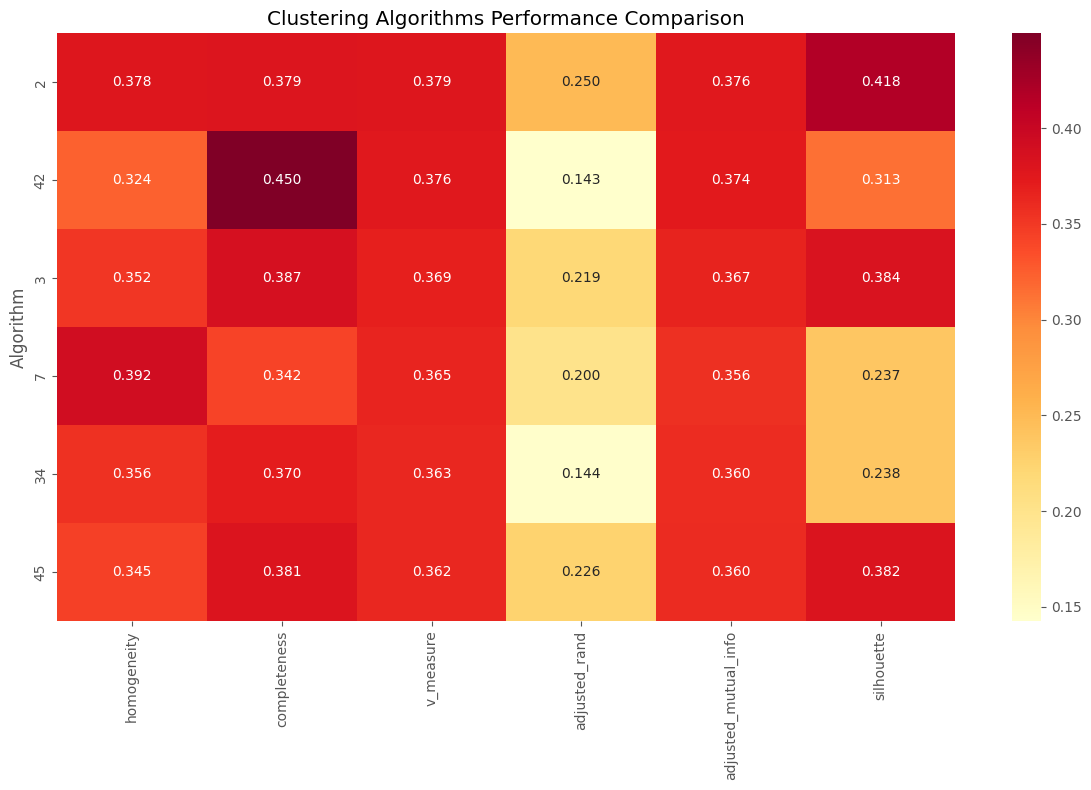

In [67]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, Birch
import umap
import hdbscan
from sklearn.metrics import *
from nltk.stem import SnowballStemmer
import re
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import seaborn as sns

# 设置随机种子
random_state = 42

# 1. 数据加载和预处理
print("Loading and preprocessing data...")

# 加载数据
newsgroups_data = fetch_20newsgroups(
    subset='all',
    random_state=random_state,
    remove=('headers', 'footers', 'quotes')
)

# 文本预处理
stemmer = SnowballStemmer("english")
def text_processor(text):
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    tokens = text.lower().split()
    return [stemmer.stem(word) for word in tokens if len(word) > 2]

# TF-IDF特征提取
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=text_processor,
    stop_words='english',
    min_df=5,
    max_df=0.85,
    ngram_range=(1,2),
    sublinear_tf=True,
    max_features=20000
)

# 转换文本数据
tfidf_vectors = tfidf_vectorizer.fit_transform(newsgroups_data.data)

# 2. 降维处理
print("Performing dimension reduction...")

# SVD降维
svd = TruncatedSVD(n_components=100, random_state=random_state)
svd_vectors = svd.fit_transform(tfidf_vectors)
svd_vectors_normalized = normalize(svd_vectors)

# UMAP降维
umap_reducer = umap.UMAP(
    n_components=10,
    n_neighbors=30,
    min_dist=0.1,
    metric='cosine',
    random_state=random_state
)
reduced_vectors = umap_reducer.fit_transform(svd_vectors_normalized)

# 标准化
scaled_vectors = StandardScaler().fit_transform(reduced_vectors)

# 3. 定义要测试的聚类算法及其参数
clustering_algorithms = {
    'KMeans': [
        KMeans(n_clusters=n_clusters, n_init=10, random_state=random_state)
        for n_clusters in [15, 20, 25]
    ],
    'Agglomerative': [
        AgglomerativeClustering(n_clusters=20, linkage=linkage)
        for linkage in ['ward', 'complete', 'average']
    ],
    'DBSCAN': [
        DBSCAN(eps=eps, min_samples=min_samples)
        for eps in [0.3, 0.5, 0.7]
        for min_samples in [10, 15, 20]
    ],
    'HDBSCAN': [
        hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            cluster_selection_epsilon=epsilon,
            cluster_selection_method='eom',
            core_dist_n_jobs=1
        )
        for min_cluster_size in [50, 80, 100]
        for min_samples in [10, 15, 20]
        for epsilon in [0.2, 0.3, 0.4]
    ],
    'Spectral': [
        SpectralClustering(
            n_clusters=20,
            n_init=10,
            affinity='nearest_neighbors',
            random_state=random_state
        )
    ],
    'BIRCH': [
        Birch(n_clusters=20, threshold=threshold)
        for threshold in [0.3, 0.5, 0.7]
    ]
}

# 4. 运行聚类算法并评估结果
results = []

for algo_name, algo_list in clustering_algorithms.items():
    print(f"\nTesting {algo_name}...")
    
    for algo in algo_list:
        try:
            start_time = time()
            
            # 聚类
            labels = algo.fit_predict(scaled_vectors)
            
            # 计算评估指标
            metrics = {
                'algorithm': algo_name,
                'parameters': str(algo.get_params()),
                'homogeneity': homogeneity_score(newsgroups_data.target, labels),
                'completeness': completeness_score(newsgroups_data.target, labels),
                'v_measure': v_measure_score(newsgroups_data.target, labels),
                'adjusted_rand': adjusted_rand_score(newsgroups_data.target, labels),
                'adjusted_mutual_info': adjusted_mutual_info_score(newsgroups_data.target, labels),
                'num_clusters': len(set(labels)) - (1 if -1 in labels else 0),
                'noise_ratio': np.sum(labels == -1) / len(labels) if -1 in labels else 0.0,
                'runtime': time() - start_time
            }
            
            # 尝试计算silhouette score
            try:
                metrics['silhouette'] = silhouette_score(
                    scaled_vectors, 
                    labels,
                    sample_size=min(10000, len(labels)),
                    random_state=random_state
                )
            except:
                metrics['silhouette'] = 0.0
                
            results.append(metrics)
            print(f"Completed {algo_name} with params: {metrics['parameters']}")
            
        except Exception as e:
            print(f"Error with {algo_name}: {str(e)}")
            continue

# 5. 分析结果
results_df = pd.DataFrame(results)

# 获取每个算法的最佳结果
best_results = results_df.loc[results_df.groupby('algorithm')['v_measure'].idxmax()]
best_results = best_results.sort_values('v_measure', ascending=False)

# 打印结果
print("\nBest results for each algorithm:")
print(best_results[['algorithm', 'v_measure', 'num_clusters', 'runtime', 'parameters']])

# 6. 可视化结果
plt.figure(figsize=(12, 8))
metrics_cols = ['homogeneity', 'completeness', 'v_measure', 
                'adjusted_rand', 'adjusted_mutual_info', 'silhouette']

sns.heatmap(best_results[metrics_cols], annot=True, fmt='.3f', cmap='YlOrRd')
plt.title('Clustering Algorithms Performance Comparison')
plt.ylabel('Algorithm')
plt.tight_layout()
plt.show()

# 7. 保存结果
best_results.to_csv('clustering_results.csv', index=False)

## test3 （报告内的结果）

Loading and preprocessing data...
Testing different dimension reduction pipelines...

Processing pipeline: SVD+UMAP
Completed SVD+UMAP: V-measure=0.366, Time=27.0s

Processing pipeline: NMF+UMAP
Completed NMF+UMAP: V-measure=0.182, Time=65.6s

Processing pipeline: UMAP
Completed UMAP: V-measure=0.504, Time=103.2s

Processing pipeline: TSNE
Error in TSNE: PCA initialization is currently not supported with the sparse input matrix. Use init="random" instead.

Processing pipeline: PCA+UMAP
Completed PCA+UMAP: V-measure=0.369, Time=36.8s

Best dimensionality reduction pipeline: UMAP
  dim_reduction  v_measure  adjusted_rand  silhouette     runtime  \
2          UMAP   0.504383       0.348608    0.356359  103.204904   
3      PCA+UMAP   0.369173       0.199636    0.425944   36.799003   
0      SVD+UMAP   0.365587       0.223764    0.398504   26.987736   
1      NMF+UMAP   0.182221       0.095458    0.428541   65.607063   

   num_clusters  
2            20  
3            20  
0            20

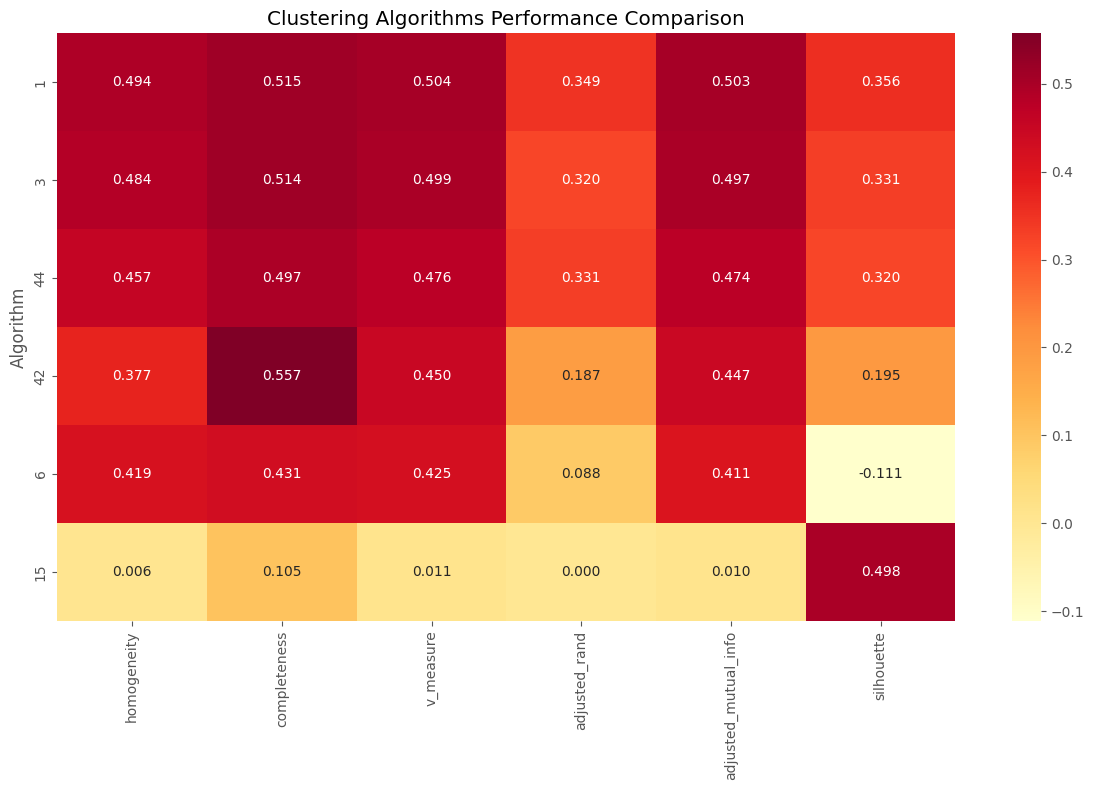

In [68]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF, PCA
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, Birch
import umap
import hdbscan
from sklearn.manifold import TSNE
from sklearn.metrics import *
from nltk.stem import SnowballStemmer
import re
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import seaborn as sns

# 设置随机种子
random_state = 42

# 1. 数据加载和预处理
print("Loading and preprocessing data...")

# 加载数据
newsgroups_data = fetch_20newsgroups(
    subset='all',
    random_state=random_state,
    remove=('headers', 'footers', 'quotes')
)

# 文本预处理
stemmer = SnowballStemmer("english")
def text_processor(text):
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    tokens = text.lower().split()
    return [stemmer.stem(word) for word in tokens if len(word) > 2]

# TF-IDF特征提取
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=text_processor,
    stop_words='english',
    min_df=5,
    max_df=0.85,
    ngram_range=(1,2),
    sublinear_tf=True,
    max_features=20000
)

# 转换文本数据
tfidf_vectors = tfidf_vectorizer.fit_transform(newsgroups_data.data)

# 2. 测试不同的降维流程并选择最优的
print("Testing different dimension reduction pipelines...")

dim_reduction_pipelines = {
    'SVD+UMAP': [
        ('svd', TruncatedSVD(n_components=100, random_state=random_state)),
        ('normalize', None),
        ('umap', umap.UMAP(n_components=10, n_neighbors=30, min_dist=0.1, metric='cosine', random_state=random_state)),
        ('scale', StandardScaler())
    ],
    'NMF+UMAP': [
        ('nmf', NMF(n_components=100, init='nndsvda', max_iter=1000, random_state=random_state)),
        ('normalize', None),
        ('umap', umap.UMAP(n_components=10, n_neighbors=30, min_dist=0.1, metric='cosine', random_state=random_state)),
        ('scale', StandardScaler())
    ],
    'UMAP': [
        ('umap', umap.UMAP(n_components=10, n_neighbors=30, min_dist=0.1, metric='cosine', random_state=random_state)),
        ('scale', StandardScaler())
    ],
    'TSNE': [
        ('tsne', TSNE(n_components=2, random_state=random_state)),
        ('scale', StandardScaler())
    ],
    'PCA+UMAP': [
        ('pca', PCA(n_components=100, random_state=random_state)),
        ('normalize', None),
        ('umap', umap.UMAP(n_components=10, n_neighbors=30, min_dist=0.1, metric='cosine', random_state=random_state)),
        ('scale', StandardScaler())
    ]
}

dim_reduction_results = []

for pipe_name, steps in dim_reduction_pipelines.items():
    print(f"\nProcessing pipeline: {pipe_name}")
    start_time = time()
    
    try:
        current_vectors = tfidf_vectors.copy()
        
        for step_info in steps:
            step_name, step = step_info
            
            if step_name == 'normalize':
                current_vectors = normalize(current_vectors)
            elif step_name == 'scale':
                scaler = StandardScaler()
                current_vectors = scaler.fit_transform(current_vectors)
            else:
                if step_name == 'pca':
                    if hasattr(current_vectors, 'toarray'):
                        current_vectors = current_vectors.toarray()
                current_vectors = step.fit_transform(current_vectors)
        
        # 评估聚类效果
        kmeans = KMeans(n_clusters=20, n_init=10, random_state=random_state)
        labels = kmeans.fit_predict(current_vectors)
        
        metrics = {
            'dim_reduction': pipe_name,
            'v_measure': v_measure_score(newsgroups_data.target, labels),
            'adjusted_rand': adjusted_rand_score(newsgroups_data.target, labels),
            'silhouette': silhouette_score(current_vectors, labels, sample_size=10000, random_state=random_state),
            'runtime': time() - start_time,
            'num_clusters': len(np.unique(labels))
        }
        
        dim_reduction_results.append(metrics)
        print(f"Completed {pipe_name}: V-measure={metrics['v_measure']:.3f}, Time={metrics['runtime']:.1f}s")
        
    except Exception as e:
        print(f"Error in {pipe_name}: {str(e)}")
        continue

# 选择最优降维流程
dim_reduction_df = pd.DataFrame(dim_reduction_results).sort_values('v_measure', ascending=False)
best_pipe_name = dim_reduction_df.iloc[0]['dim_reduction']
best_pipe_steps = dim_reduction_pipelines[best_pipe_name]

print("\nBest dimensionality reduction pipeline:", best_pipe_name)
print(dim_reduction_df)

# 应用最优流程
print(f"\nApplying best pipeline: {best_pipe_name}")
current_vectors = tfidf_vectors.copy()
for step_info in best_pipe_steps:
    step_name, step = step_info
    if step_name == 'normalize':
        current_vectors = normalize(current_vectors)
    elif step_name == 'scale':
        scaler = StandardScaler()
        current_vectors = scaler.fit_transform(current_vectors)
    else:
        if step_name == 'pca':
            if hasattr(current_vectors, 'toarray'):
                current_vectors = current_vectors.toarray()
        current_vectors = step.fit_transform(current_vectors)

scaled_vectors = current_vectors

# 3. 定义要测试的聚类算法及其参数
clustering_algorithms = {
    'KMeans': [
        KMeans(n_clusters=n_clusters, n_init=10, random_state=random_state)
        for n_clusters in [15, 20, 25]
    ],
    'Agglomerative': [
        AgglomerativeClustering(n_clusters=20, linkage=linkage)
        for linkage in ['ward', 'complete', 'average']
    ],
    'DBSCAN': [
        DBSCAN(eps=eps, min_samples=min_samples)
        for eps in [0.3, 0.5, 0.7]
        for min_samples in [10, 15, 20]
    ],
    'HDBSCAN': [
        hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            cluster_selection_epsilon=epsilon,
            cluster_selection_method='eom',
            core_dist_n_jobs=1
        )
        for min_cluster_size in [50, 80, 100]
        for min_samples in [10, 15, 20]
        for epsilon in [0.2, 0.3, 0.4]
    ],
    'Spectral': [
        SpectralClustering(
            n_clusters=20,
            n_init=10,
            affinity='nearest_neighbors',
            random_state=random_state
        )
    ],
    'BIRCH': [
        Birch(n_clusters=20, threshold=threshold)
        for threshold in [0.3, 0.5, 0.7]
    ]
}

# 4. 运行聚类算法并评估结果
results = []

for algo_name, algo_list in clustering_algorithms.items():
    print(f"\nTesting {algo_name}...")
    
    for algo in algo_list:
        try:
            start_time = time()
            
            # 聚类
            labels = algo.fit_predict(scaled_vectors)
            
            # 计算评估指标
            metrics = {
                'algorithm': algo_name,
                'parameters': str(algo.get_params()),
                'homogeneity': homogeneity_score(newsgroups_data.target, labels),
                'completeness': completeness_score(newsgroups_data.target, labels),
                'v_measure': v_measure_score(newsgroups_data.target, labels),
                'adjusted_rand': adjusted_rand_score(newsgroups_data.target, labels),
                'adjusted_mutual_info': adjusted_mutual_info_score(newsgroups_data.target, labels),
                'num_clusters': len(set(labels)) - (1 if -1 in labels else 0),
                'noise_ratio': np.sum(labels == -1) / len(labels) if -1 in labels else 0.0,
                'runtime': time() - start_time
            }
            
            # 尝试计算silhouette score
            try:
                metrics['silhouette'] = silhouette_score(
                    scaled_vectors, 
                    labels,
                    sample_size=min(10000, len(labels)),
                    random_state=random_state
                )
            except:
                metrics['silhouette'] = 0.0
                
            results.append(metrics)
            print(f"Completed {algo_name} with params: {metrics['parameters']}")
            
        except Exception as e:
            print(f"Error with {algo_name}: {str(e)}")
            continue

# 5. 分析结果
results_df = pd.DataFrame(results)

# 获取每个算法的最佳结果
best_results = results_df.loc[results_df.groupby('algorithm')['v_measure'].idxmax()]
best_results = best_results.sort_values('v_measure', ascending=False)

# 打印结果
print("\nBest results for each algorithm:")
print(best_results[['algorithm', 'v_measure', 'num_clusters', 'runtime', 'parameters']])

# 6. 可视化结果
plt.figure(figsize=(12, 8))
metrics_cols = ['homogeneity', 'completeness', 'v_measure', 
                'adjusted_rand', 'adjusted_mutual_info', 'silhouette']

sns.heatmap(best_results[metrics_cols], annot=True, fmt='.3f', cmap='YlOrRd')
plt.title('Clustering Algorithms Performance Comparison')
plt.ylabel('Algorithm')
plt.tight_layout()
plt.show()

# 7. 保存结果
best_results.to_csv('clustering_results.csv', index=False)

In [69]:
best_results

,algorithm,parameters,homogeneity,completeness,v_measure,adjusted_rand,adjusted_mutual_info,num_clusters,noise_ratio,runtime,silhouette
1,KMeans,"{'algorithm': 'lloyd', 'copy_x': True, 'init':...",0.494172,0.515025,0.504383,0.348608,0.502731,20,0.000000,0.650893,0.356359
3,Agglomerative,"{'compute_distances': False, 'compute_full_tre...",0.484434,0.514122,0.498837,0.319708,0.497150,20,0.000000,10.137441,0.330584
44,BIRCH,"{'branching_factor': 50, 'compute_labels': Tru...",0.456569,0.496957,0.475908,0.331368,0.474121,20,0.000000,0.440065,0.320253
42,Spectral,"{'affinity': 'nearest_neighbors', 'assign_labe...",0.377010,0.557084,0.449690,0.186870,0.447451,20,0.000000,54.813425,0.194785
6,DBSCAN,"{'algorithm': 'auto', 'eps': 0.3, 'leaf_size':...",0.418730,0.430849,0.424703,0.088401,0.410989,124,0.377321,0.549528,-0.110767
15,HDBSCAN,"{'algorithm': 'best', 'allow_single_cluster': ...",0.006048,0.105337,0.011440,0.000131,0.010414,3,0.001380,1.264269,0.497707


In [70]:
best_results['parameters']

1     {'algorithm': 'lloyd', 'copy_x': True, 'init':...
3     {'compute_distances': False, 'compute_full_tre...
44    {'branching_factor': 50, 'compute_labels': Tru...
42    {'affinity': 'nearest_neighbors', 'assign_labe...
6     {'algorithm': 'auto', 'eps': 0.3, 'leaf_size':...
15    {'algorithm': 'best', 'allow_single_cluster': ...
Name: parameters, dtype: object